## My goal is to reduce the type II error, specifically the false negative errors.

In [1]:
!pip install --quiet --no-cache-dir scikit-learn==1.5.2 imbalanced-learn==0.12.3 xgboost==2.1.1 lightgbm==4.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 242.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 289.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 233.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 232.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv


In [3]:
# Some libraries for data analysis
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',20)

df=pd.read_csv('/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


## Data Analysis
 * Checking for null values and duplicate entries
*  Gathering information about the columns in the dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [5]:
def checking_null_duplicate(df):
    null=df.isna().sum()
    print("The data contians {}".format(null))
    duplicate_values=df.duplicated().sum()
    print("The data contains {} duplicate values".format(duplicate_values))
    print("The data contain {} rows and {} columns".format(df.shape[0],df.shape[1]))
checking_null_duplicate(df)

The data contians gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64
The data contains 3854 duplicate values
The data contain 100000 rows and 9 columns


In [6]:
percentage=((3854/len(df))*100)
print(f'The duplicate value {percentage:.2f}')

The duplicate value 3.85


In [7]:
# Checking the duplicate values 
def checking_duplicate_value(df,key_columns=None):
    print('Checking for duplictate \n')
    total_duplicate=df.duplicated().sum()
    print('Total Duplicated {} values found'.format(total_duplicate))
    for col in df.columns:
        duplicate_val=df.duplicated(subset=[col]).sum()
        print(f'{col}:{duplicate_val} duplicate values')
    print('\n duplicate columns in the data')
    display(df[df.duplicated()].head())
    print('\n orignal data frame')
    display(df.head())
# Checking the duplicate values in the data  
checking_duplicate_value(df,key_columns=None)

Checking for duplictate 

Total Duplicated 3854 values found
gender:99997 duplicate values
age:99898 duplicate values
hypertension:99998 duplicate values
heart_disease:99998 duplicate values
smoking_history:99994 duplicate values
bmi:95753 duplicate values
HbA1c_level:99982 duplicate values
blood_glucose_level:99982 duplicate values
diabetes:99998 duplicate values

 duplicate columns in the data


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
2756,Male,80.0,0,0,No Info,27.32,6.6,159,0
3272,Female,80.0,0,0,No Info,27.32,3.5,80,0
3418,Female,19.0,0,0,No Info,27.32,6.5,100,0
3939,Female,78.0,1,0,former,27.32,3.5,130,0
3960,Male,47.0,0,0,No Info,27.32,6.0,200,0



 orignal data frame


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


## Remove the duplicate values, should I remove or not?
* In these problems, I first refer to some information on Google. If we want to remove duplicate values, we need to check what type of duplicates they are, so I can understand the data with an example.
    * Customer ID	Purchase Amount
         C001	           100
         C001	           150
* In this case, two customers made two purchases; they may be regular customers, so do not remove them.

  * Product	 |  Price
    Shoes	  |   100
    Shoes	    | 100
    Bag	       |  150
* Here, we have the same product listed with the same price. This raises the question of whether we should remove these duplicates. Based on the previous example, we see that duplicates in some contexts, like customer purchases, may not be problematic. However, in situations like product listings where the same item appears multiple times with the same price, it does make sense to consider removing such duplicates.

* In conclusion, I believe that the decision to remove duplicates should depend on the context. In cases such as Body Mass Index (BMI), where values may average out but other parameters like age and heart disease status differ, the entries are not truly duplicates. Therefore, I chose not to remove them.


In [8]:
# Some Statistics information 
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


# on the basic aspects of data analysis, without going into too much depth

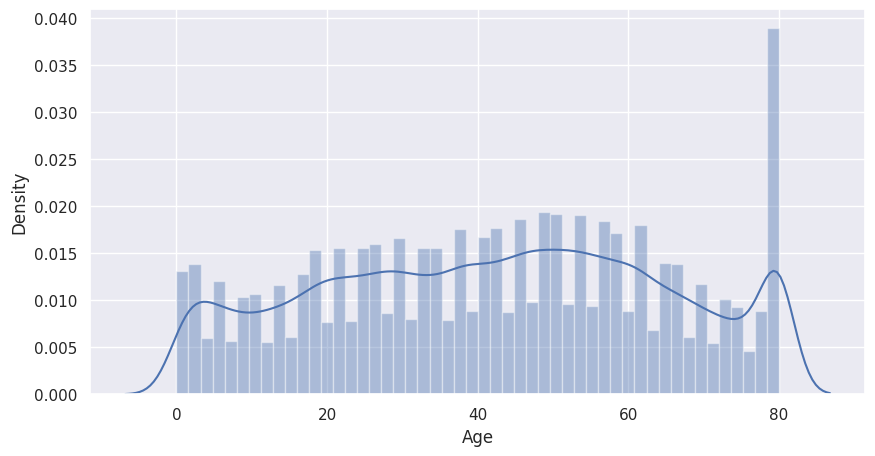

In [9]:
# Age distribution
df['age']=df['age'].astype(int)
plt.figure(figsize=(10,5))
sns.set_theme(style='darkgrid')
ax=sns.distplot(df['age'])
ax.set_xlabel('Age')
ax.set_ylabel('Density')
plt.show()

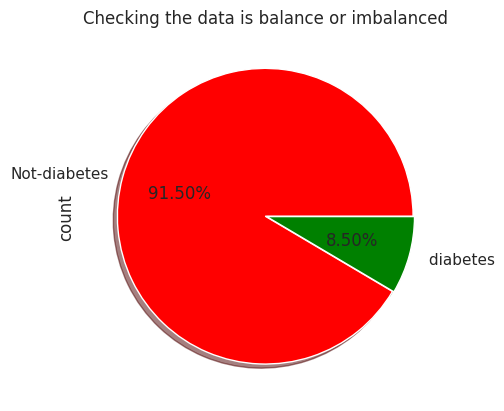

In [10]:
# Checking the output is balanced and imbalanced data
sns.set_theme(style='whitegrid')
df['diabetes'].value_counts().plot(kind='pie',
    explode=[0,0.01],
    labels=['Not-diabetes',' diabetes'],
    colors=['red', 'green'],
    autopct='%1.2f%%',
    shadow=True)
plt.title('Checking the data is balance or imbalanced')
plt.show()

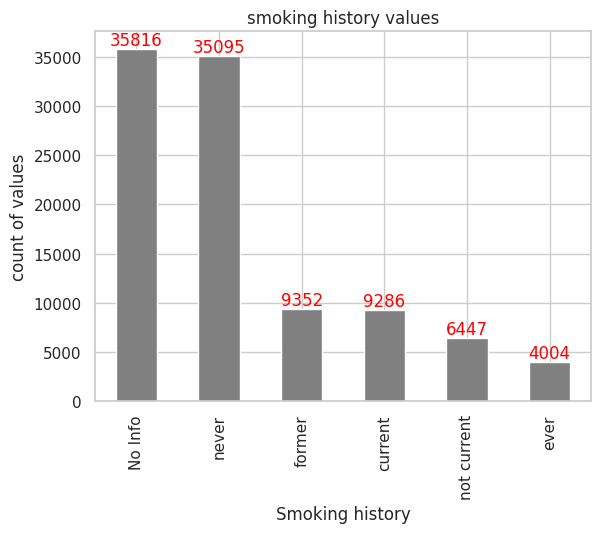

In [11]:
ax=df['smoking_history'].value_counts().plot(kind='bar',color='gray')
ax.bar_label(ax.containers[0],color='red',fontsize=12)
ax.set_title('smoking history values')
ax.set_xlabel('Smoking history')
ax.set_ylabel('count of values')
plt.show()

# Machine Learning Model:
 > We mainly focus on two steps in the process: normal machine learning and working with imbalanced data. We use techniques to handle imbalanced data.
>We primarily focus on two steps in the process: standard machine learning and addressing imbalanced data. We implement various techniques to handle data imbalances.
> First, we utilise a standard machine learning model.  
> Second, we address the issue of imbalanced data.

In [12]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80,0,1,never,25.19,6.6,140,0
1,Female,54,0,0,No Info,27.32,6.6,80,0
2,Male,28,0,0,never,27.32,5.7,158,0
3,Female,36,0,0,current,23.45,5.0,155,0
4,Male,76,1,1,current,20.14,4.8,155,0


LogisticRegression() model score is 0.9532 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     18347
           1       0.79      0.59      0.68      1653

    accuracy                           0.95     20000
   macro avg       0.88      0.79      0.83     20000
weighted avg       0.95      0.95      0.95     20000



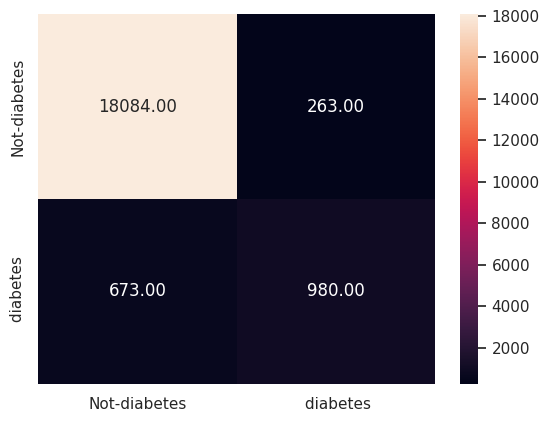

In [13]:
#Machine Learning building
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_curve,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Label encoder the category values
def label_coder(df):
    label=LabelEncoder()
    return label.fit_transform(df)
df['gender']=label_coder(df['gender'])
df['smoking_history']=label_coder(df['smoking_history'])
# Split the data into dependent and independent
X=df.drop('diabetes',axis=1)
y=df['diabetes']

#split the data into train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=200)

# Model buliding part
def model_prediction(model,X_train,X_test,y_train,y_test):
    # Let's fit the model with train data
    model.fit(X_train,y_train)
    # Prediction
    y_pred=model.predict(X_test)
    accurc_score=accuracy_score(y_test,y_pred)
    print('{} model score is {} '.format(model,accurc_score))
    confusion=confusion_matrix(y_test,y_pred)
    sns.heatmap(confusion,annot=True,fmt='.2f',xticklabels=['Not-diabetes',' diabetes'],yticklabels=['Not-diabetes',' diabetes'])
    clas=classification_report(y_test,y_pred)
    print(clas)
logistic=LogisticRegression()
model_prediction(logistic,X_train,X_test,y_train,y_test)

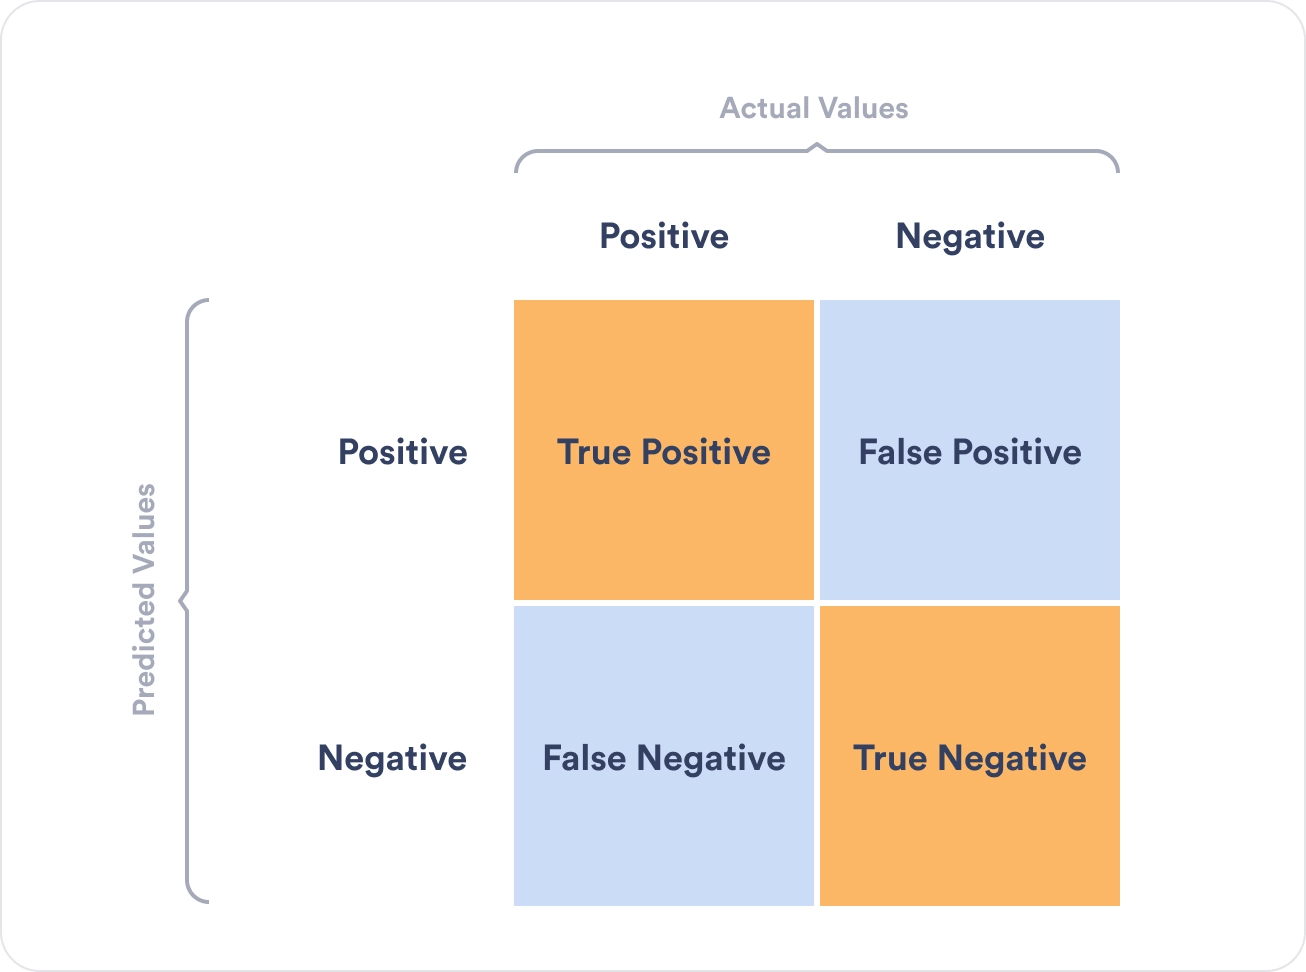
# About Confusion Matrix:
* During my last interview, the interviewer asked about the confusion matrix, so I worked on that. A confusion matrix has four values.
  
> TP - True positive means the model correctly predicts that 18,126 people do not have diabetes.
>>TN - True positive means the model correctly predicts that 18,126 people do not have diabetes.
>>> FP - False positives mean 166 people do not have diabetes, but it is predicted that they do. This is also called a type 1 error.
>>>FN - False negatives occur when 692 people have diabetes, but the test incorrectly predicts they do not have it. This is also known as a Type II error.
*  My goal is to reduce the number of false negatives in diabetes predictions. This means that there are 692 people who actually have diabetes but are predicted not to have it, which may lead to an increase in their blood sugar levels, especially if they consume sweets. Additionally, this can decrease their overall lifespan. As a data scientist, how would you approach this type of question in an interview?

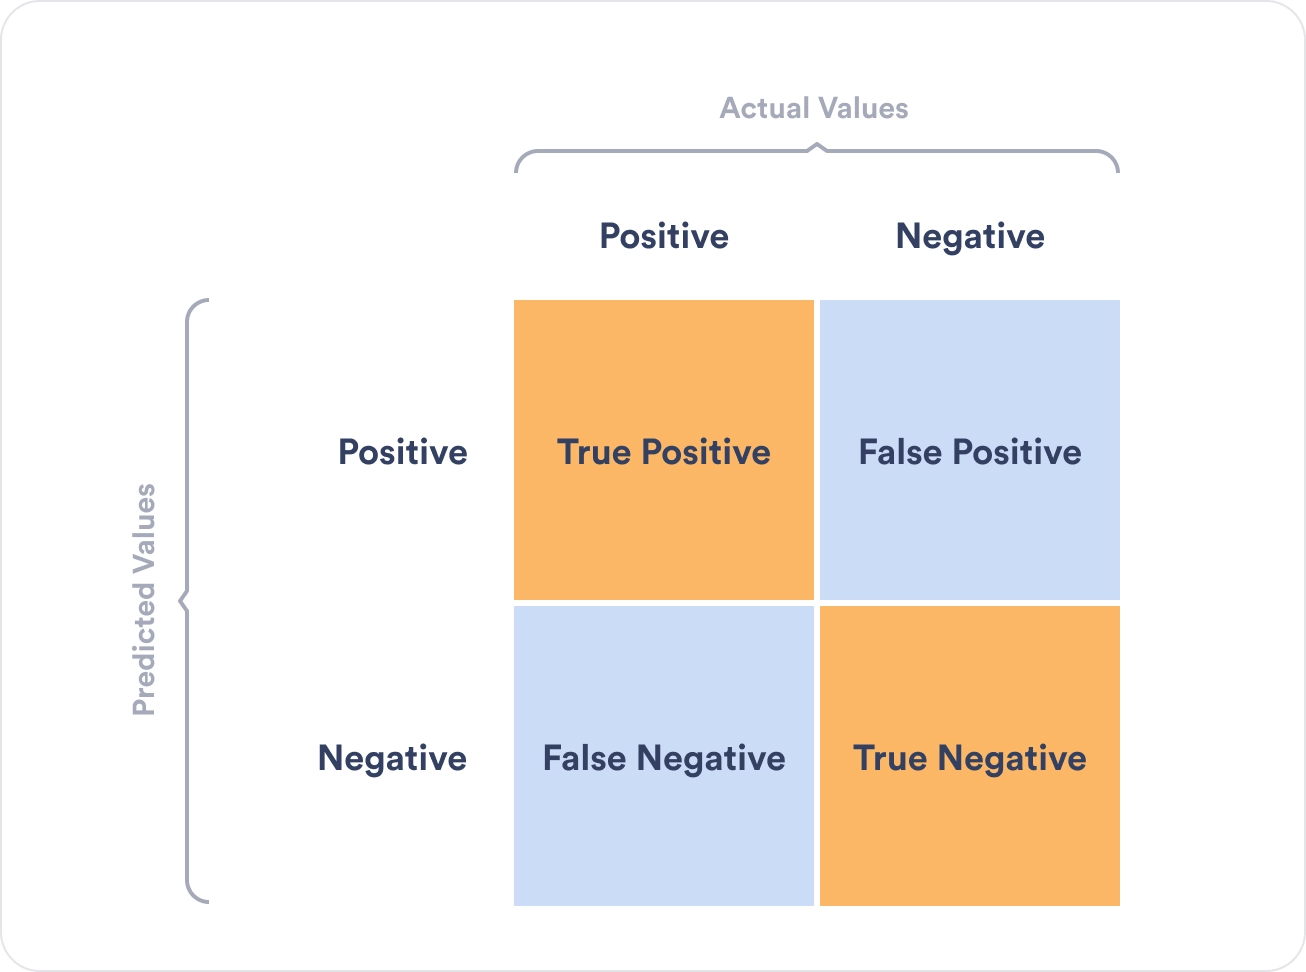

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     18347
           1       0.39      0.87      0.54      1653

    accuracy                           0.88     20000
   macro avg       0.69      0.87      0.74     20000
weighted avg       0.94      0.88      0.90     20000



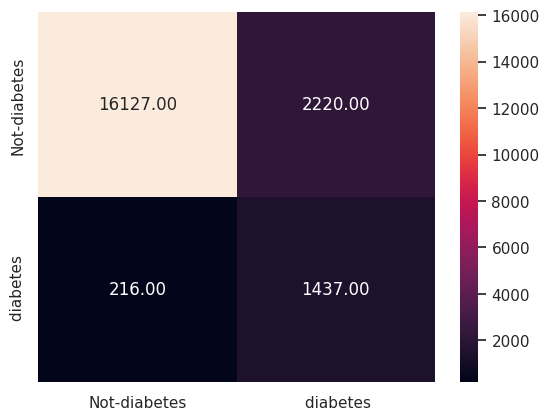

In [14]:
# Let's apply threshlod method to reduce the false negative
logistic=LogisticRegression(class_weight='balanced')
# Fit the model with train data
logistic.fit(X_train,y_train)
# prediction of the data
logistic_pred=logistic.predict(X_test)
# let's apply the threshold 0.5 to 0.3
after_logistic_pred=np.where(logistic_pred > 0.3,1,0)
matrix=confusion_matrix(y_test,after_logistic_pred)
sns.heatmap(matrix,annot=True,fmt='.2f',xticklabels=['Not-diabetes',' diabetes'],yticklabels=['Not-diabetes',' diabetes'])
print(classification_report(y_test,after_logistic_pred))
plt.show()

### To apply the threshold, the false negative rate decreases, but the false positive rate increases. For this reason, I moved to the ensemble technique to further reduce the false negative rate.

RandomForestClassifier(random_state=42) model score is 0.97055 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18347
           1       0.94      0.69      0.79      1653

    accuracy                           0.97     20000
   macro avg       0.96      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000



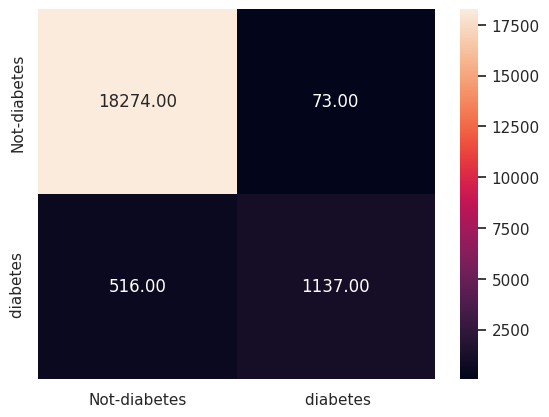

In [15]:
# Random Forest classifier Ensemble method
random=RandomForestClassifier(n_estimators=100,random_state=42)
model_prediction(random,X_train,X_test,y_train,y_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...) model score is 0.9717 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18347
           1       0.95      0.69      0.80      1653

    accuracy                           0.97     20

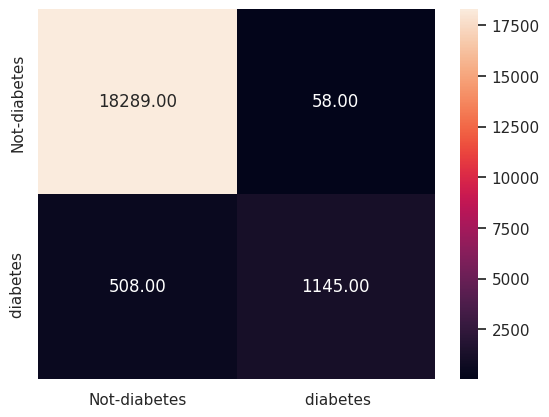

In [16]:
from xgboost import XGBClassifier
xgb=XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
model_prediction(xgb,X_train,X_test,y_train,y_test)

### For the ensemble technique, I achieved a decrease in the false negative rate, but the model was not performing well overall. As data scientists or domain experts, we prioritize reducing false negatives and false positives, with a particular focus on false negatives. This is crucial because we cannot afford to miss diabetes patients, so we need to improve in this area. I explored various methods and applied techniques such as hyperparameter tuning and addressing class imbalance. I evaluated both models and made decisions based on their performances.


RandomForestClassifier(random_state=42) model score is 0.9363


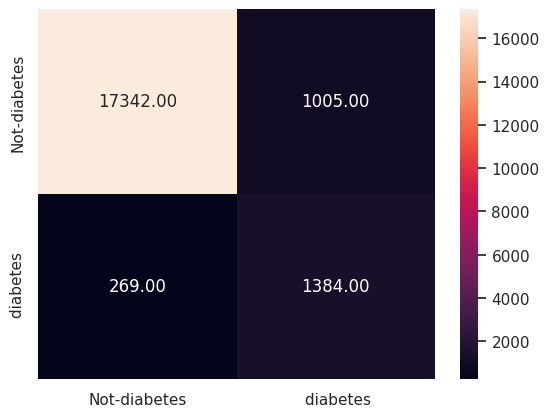

In [17]:
# RandomForest hyperparameter turning
param={
    'n_estimators':[100,120,150,140],
    'max_depth': [6, 10, 15],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}
random_grid=GridSearchCV(RandomForestClassifier(),param_grid=param,scoring='f1',cv=3,n_jobs=-1)
random_grid.fit(X_train,y_train)
random_pred=random_grid.predict(X_test)
confusion=confusion_matrix(y_test,random_pred)
score=accuracy_score(y_test,random_pred)
print('{} model score is {}'.format(random,score))
sns.heatmap(confusion,annot=True,fmt='.2f',xticklabels=['Not-diabetes',' diabetes'],yticklabels=['Not-diabetes',' diabetes'])
plt.show()

Fitting 5 folds for each of 108 candidates, totalling 540 fits


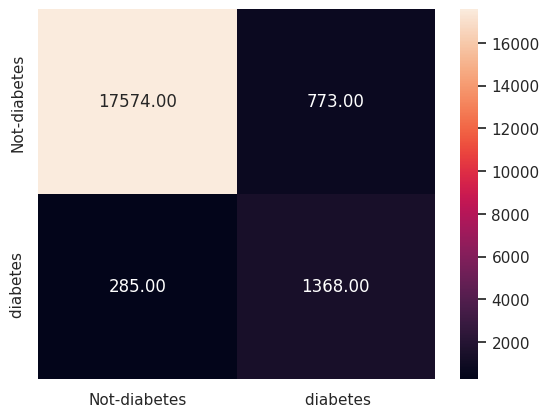

In [18]:
from sklearn.metrics import make_scorer, fbeta_score

# Define F2-score as the scoring metric (beta=2 for recall importance)
f2_scorer = make_scorer(fbeta_score, beta=2)

# Define parameter grid
param_grid = {
    'scale_pos_weight': [1, 5, 10, 20],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialize XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Perform GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring=f2_scorer, cv=5, verbose=1, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
# Predictions
grid_search_xgb_pred=grid_search_xgb.predict(X_test)
grid_xgb_matrix=confusion_matrix(y_test,grid_search_xgb_pred)
sns.heatmap(grid_xgb_matrix,annot=True,fmt='.2f',xticklabels=['Not-diabetes',' diabetes'],yticklabels=['Not-diabetes',' diabetes'])
plt.show()

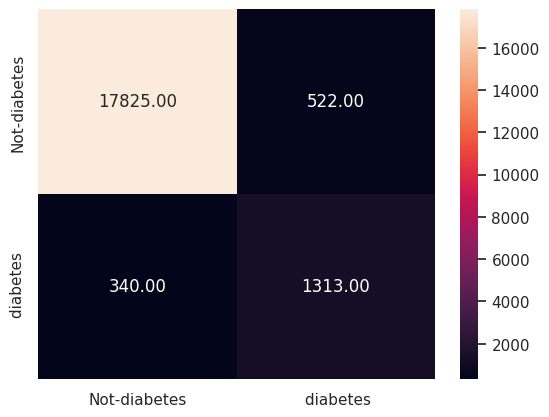

In [19]:
# Another ensemble method to 
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[ ('xgb', xgb), ('lr', logistic),('random',random_grid)],
    voting='soft'
)
ensemble.fit(X_train, y_train)
ensemble_pred=ensemble.predict(X_test)
voting_matrix=confusion_matrix(y_test,ensemble_pred)
sns.heatmap(voting_matrix,annot=True,fmt='.2f',xticklabels=['Not-diabetes',' diabetes'],yticklabels=['Not-diabetes',' diabetes'])
plt.show()

## Imbalanced technique:
> Our aim is to reduce the false negative rate (Type II error).
We tried different methods, and one of them was using an imbalanced data handling technique.
We chose this method because our dataset had an unequal distribution of output labels — the number of diabetes cases was much smaller compared to non-diabetes cases.

> For example, before applying the technique, there were about 1,000 diabetes samples and 9,000 non-diabetes samples.
After applying the imbalance handling method, the data became balanced, with around 5,000 diabetes samples and 5,000 non-diabetes samples.
This equal distribution helps the model learn both classes effectively and reduces the chances of missing positive (diabetes) cases.

RandomForestClassifier(random_state=42) model score is 0.97055


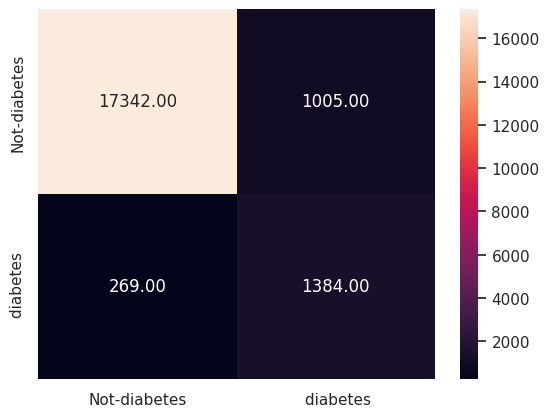

In [20]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(random_state=45)
X_res,y_res=smote.fit_resample(X_train,y_train)
random_grid.fit(X_res,y_res)
random_gird_sam_pred=random.predict(X_test)
score_random=accuracy_score(y_test,random_gird_sam_pred)
print('{} model score is {}'.format(random,score_random))
confusion_matrix_val=confusion_matrix(y_test,random_gird_sam_pred)
sns.heatmap(confusion,annot=True,fmt='.2f',xticklabels=['Not-diabetes',' diabetes'],yticklabels=['Not-diabetes',' diabetes'])
plt.show()

In [21]:
from imblearn.over_sampling import RandomOverSampler
os=RandomOverSampler()
X_res,y_res=os.fit_resample(X_train,y_train)
xgb.fit(X_res,y_res)
x_gb_pred=xgb.predict(X_test)
confusion_matrix(y_test,x_gb_pred)

array([[16973,  1374],
       [  207,  1446]])

## Finally note about the diabetes prediction:
> Based on the performance metrics, the Voting Classifier gave the best results, with Type I and Type II errors being nearly equal, though not exactly the same. Its performance was slightly better than the other models.

> During my interview, I was asked about the confusion matrix and how to interpret and reduce these errors. To strengthen my understanding, I implemented this practical experiment to clearly study the false negative rate and its impact on model performance.

> The other methods also performed well, but they had a higher Type I error compared to Type II. Through this research, I gained a clear understanding that in classification tasks, especially with imbalanced data, the main focus should be on reducing false negatives rather than just improving accuracy.